In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# Install the splitfolders library
!pip install split-folders

import splitfolders

# Input folder where the 5 classes are located
input_folder = "/content/drive/MyDrive/MLPR Images-20241219T100019Z-001/MLPR Images"

# Output folder for train/val/test splits
output_folder = "/content/split_data"

# Split the data (80% train, 10% validation, 10% test)
splitfolders.ratio(input_folder,
                   output=output_folder,
                   seed=42,
                   ratio=(0.8, 0.1, 0.1),
                   group_prefix=None)


In [ ]:

# Function to visualize samples from a dataset
def visualize_samples(folder, title, num_samples=5):
    """
    Visualize random samples from the specified dataset folder.
    :param folder: Path to dataset folder (e.g., train, val, test)
    :param title: Title for the plot
    :param num_samples: Number of images to visualize
    """
    class_folders = [os.path.join(folder, cls) for cls in os.listdir(folder)]
    class_folders = [f for f in class_folders if os.path.isdir(f)]

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        # Pick a random class
        selected_class = random.choice(class_folders)
        # Pick a random image from the selected class
        img_path = os.path.join(selected_class, random.choice(os.listdir(selected_class)))
        img = Image.open(img_path)

        # Plot the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(selected_class))

    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualize samples from train, val, and test datasets
visualize_samples(os.path.join("/content/split_data", "train"), "Training Samples")
visualize_samples(os.path.join("/content/split_data", "val"), "Validation Samples")
visualize_samples(os.path.join("/content/split_data", "test"), "Test Samples")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to the split data
train_dir = '/content/split_data/train'
val_dir = '/content/split_data/val'
test_dir = '/content/split_data/test'

# Data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255,   # Normalize pixel values
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Rescale validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of image data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images
    batch_size=32,
    class_mode='categorical')  # For multi-class classification

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')


In [ ]:
class_names = train_generator.class_names

In [ ]:
from tensorflow.keras import models, layers

# Assuming the input images are of shape 32x32 with 3 channels (RGB)
model = models.Sequential()

# Add convolutional and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout for regularization

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout for regularization

model.add(layers.Conv2D(128, (3, 3), activation='relu'))

# Flatten and add Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(10, activation='softmax'))  # Assuming 10 output classes

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),  # Flatten the 3D feature maps into 1D vectors
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Update for 6 classes
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Dataset loading and preprocessing
train_dir_path = "/content/split_data/train"
train_dir = tf.keras.utils.image_dataset_from_directory(
    train_dir_path,
    image_size=(150, 150),
    batch_size=32,
    label_mode='int'  # Integer labels for sparse_categorical_crossentropy
)

# Normalize the dataset
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_dir = train_dir.map(preprocess)

# Split into training and validation datasets
val_size = int(tf.data.experimental.cardinality(train_dir).numpy() * 0.2)
val_dataset = train_dir.take(val_size)
train_dataset = train_dir.skip(val_size)

# Shuffle training dataset
train_dataset = train_dataset.shuffle(1000)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)


In [ ]:


# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Transfer learning


In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
class_names = ['Product_1','Product_2','Product_3','Product_4','Product_5','Background']

In [ ]:
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [ ]:
transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_transfer = transfer_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

# NEW TRY

In [ ]:
#CNN

In [ ]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install the splitfolders library
!pip install split-folders

import splitfolders

# Input folder where the 5 classes are located
input_folder = "/content/drive/MyDrive/MLPR Images-20241219T100019Z-001/MLPR Images"

# Output folder for train/val/test splits
output_folder = "/content/split_data"

# Split the data (80% train, 20%test)
splitfolders.ratio(input_folder,
                   output=output_folder,
                   seed=42,
                   ratio=(0.8, 0.2),
                   group_prefix=None)


Copying files: 1938 files [00:16, 114.84 files/s]


In [ ]:


# Load the dataset using image_dataset_from_directory
train_dir = "/content/split_data/train"
val_dir = "/content/split_data/val"


# Load datasets with appropriate preprocessing
train_dataset = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',  # Multi-class classification with one-hot encoding
    batch_size=32,
    image_size=(150, 150),
    shuffle=True
)

val_dataset = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)

# Class names
class_names = train_dataset.class_names
print(f"Classes: {class_names}")


Found 1550 files belonging to 6 classes.
Found 388 files belonging to 6 classes.
Classes: ['Background', 'Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5']


In [ ]:
# Calculate class weights to handle imbalance
y_train = np.concatenate([y.numpy() for x, y in train_dataset], axis=0)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.arange(len(class_names)),
    y=np.argmax(y_train, axis=1)
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")


Class Weights: {0: 8.333333333333334, 1: 0.6458333333333334, 2: 23.484848484848484, 3: 0.8072916666666666, 4: 0.8387445887445888, 5: 0.5381944444444444}


In [ ]:
# Build a simple CNN model
cnn_model = models.Sequential([
    layers.InputLayer(input_shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_cnn = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=10
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.3587 - loss: 464.4607 - val_accuracy: 0.1701 - val_loss: 1.7072
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4582 - loss: 1.3407 - val_accuracy: 0.3119 - val_loss: 1.6621
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5177 - loss: 1.5658 - val_accuracy: 0.3892 - val_loss: 1.4370
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5647 - loss: 1.1216 - val_accuracy: 0.3479 - val_loss: 1.5573
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4908 - loss: 1.2018 - val_accuracy: 0.3531 - val_loss: 1.5091
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5541 - loss: 0.9588 - val_accuracy: 0.5052 - val_loss: 1.2480
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.6163 - loss: 0.8070 - val_accuracy: 0.5593 - val_loss: 1.0915
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6889 - loss: 0.6963 - val_accuracy: 0.6881 - val_lo

In [ ]:
# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


print("Base model layers ",len(base_model.layers))
# Fine-tuning: Unfreeze the top layers of the base model
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers initially

# Add custom layers
transfer_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_transfer = transfer_model.fit(
    train_dataset,
    validation_data=val_dataset,
    class_weight=class_weights_dict,
    epochs=10
)



Base model layers  175
Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.5926 - loss: 1.3971 - val_accuracy: 0.6392 - val_loss: 1.2145
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.8637 - loss: 0.3126 - val_accuracy: 0.8789 - val_loss: 0.3137
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9505 - loss: 0.1379 - val_accuracy: 0.7113 - val_loss: 1.0450
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.9132 - loss: 0.1716 - val_accuracy: 0.9485 - val_loss: 0.1206
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9678 - loss: 0.0593 - val_accuracy: 0.9716 - val_loss: 0.0774
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9803 - loss: 0.0354 - val_accuracy: 0.9691 - val_loss: 0.0706
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9882 - loss: 0.0263 - val_accuracy: 0.9691 - val_loss: 0.0733
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9926 - loss: 0.0232 - v

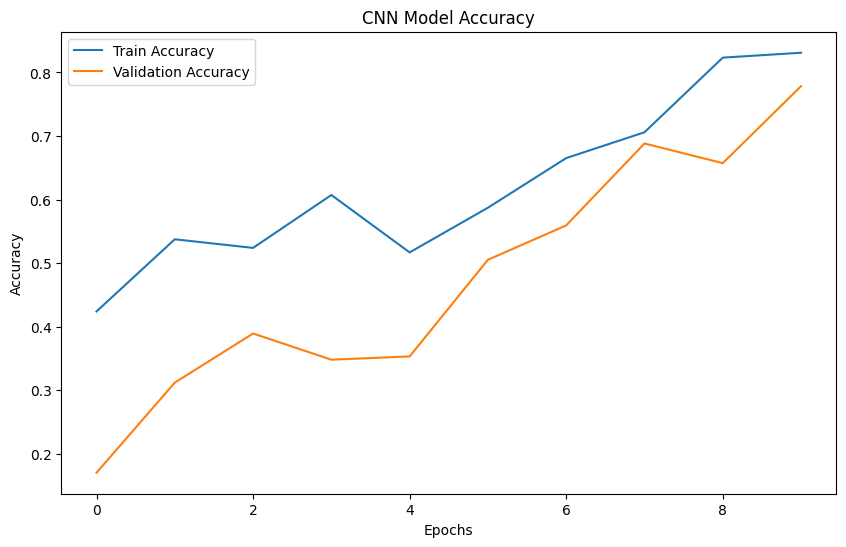

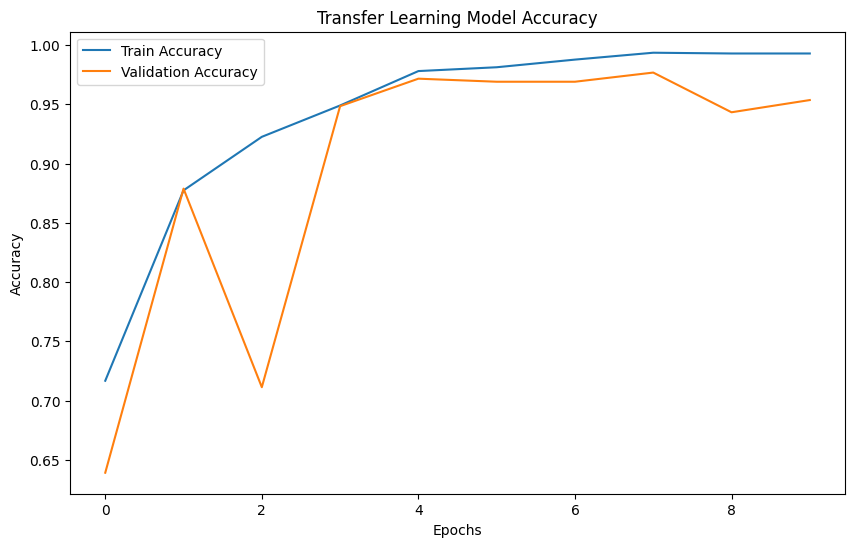

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 577ms/step - accuracy: 0.8094 - loss: 1.0985
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.9597 - loss: 0.1056
CNN Model - Loss: 1.2013921737670898, Accuracy: 0.7783505320549011
Transfer Learning Model - Loss: 0.0999646708369255, Accuracy: 0.9536082744598389


In [ ]:
# Plot training and validation accuracy for both models
def plot_history(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history_cnn, "CNN Model Accuracy")
plot_history(history_transfer, "Transfer Learning Model Accuracy")

# Evaluate on validation dataset
cnn_eval = cnn_model.evaluate(val_dataset)
transfer_eval = transfer_model.evaluate(val_dataset)

print(f"CNN Model - Loss: {cnn_eval[0]}, Accuracy: {cnn_eval[1]}")
print(f"Transfer Learning Model - Loss: {transfer_eval[0]}, Accuracy: {transfer_eval[1]}")


In [ ]:
#Unfreeze base model
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  175


In [ ]:
base_learning_rate = 0.0001

In [ ]:
transfer_model.compile(loss='categorical_crossentropy',
              optimizer ='adam',
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [ ]:
len(transfer_model.trainable_variables)

4

In [ ]:
fine_tune_epochs = 10
total_epochs =  10 + fine_tune_epochs

history_fine = transfer_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history_transfer.epoch),
                         validation_data=val_dataset)

Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.9947 - loss: 0.0471 - val_accuracy: 0.9863 - val_loss: 0.0953
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9878 - loss: 0.1122 - val_accuracy: 0.9841 - val_loss: 0.1243
Epoch 13/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9983 - loss: 0.0230 - val_accuracy: 0.9957 - val_loss: 0.0524
Epoch 14/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9997 - loss: 0.0122 - val_accuracy: 0.9931 - val_loss: 0.0879
Epoch 15/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9991 - loss: 0.0155 - val_accuracy: 0.9880 - val_loss: 0.0949
Epoch 16/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9988 - loss: 0.0114 - val_accuracy: 0.9966 - val_loss: 0.0551
Epoch 17/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.9991 - loss: 0.0103 - val_accuracy: 0.9914 - val_loss: 0.0894
Epoch 18/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9998 - loss: 0.0044 - val_accuracy: 0.

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']
print(acc,loss)

[0.994946300983429, 0.9905375838279724, 0.9983870387077332, 0.999569833278656, 0.9990322589874268, 0.9984946250915527, 0.9993548393249512, 0.9995698928833008, 0.9993548393249512, 0.9997850060462952] [0.05210196226835251, 0.08899661153554916, 0.02190905623137951, 0.01120560523122549, 0.015081825666129589, 0.013273142278194427, 0.009593506343662739, 0.0056519838981330395, 0.009906786493957043, 0.005249613896012306]


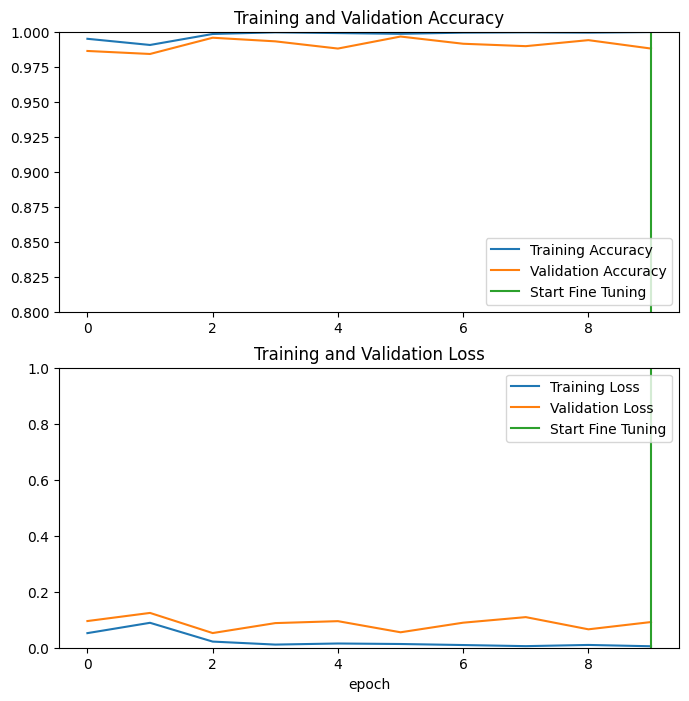

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([10-1,10-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([10-1,10-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = transfer_model.evaluate(train_dataset)
print('Test accuracy :', accuracy)

49/49 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.9992 - loss: 0.0103
Test accuracy : 0.9993548393249512


In [ ]:
print(loss)

0.008246384561061859


# Try
